In [186]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.auto import tqdm
import seaborn as sns
import pingouin as pg
plt.style.use('ggplot')
%matplotlib inline

In [203]:
#функция для бутстрапа 
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 10000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}


In [162]:
data1 = pd.read_csv ('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-fomenko-22/stat/hw_bootstrap.csv', sep=';')
data1.dtypes #нужно поменять тип данных для value

Unnamed: 0            int64
value                object
experimentVariant    object
dtype: object

In [163]:
data1['value']=data1['value'].str.replace(',','.') #сменим запятые на точки, чтобы можно было перевести value в float
data1 = data1.astype({'value':'float'}) #переводим в числа
data1 = data1.drop(columns='Unnamed: 0') 

In [164]:
data1[data1['experimentVariant']=="Treatment"].describe()
#максимальное значение аномально высокое

,value
count,500.000000
mean,27.321499
std,186.557011
min,6.436541
25%,9.421968
50%,10.025847
75%,10.675721
max,3000.000000


In [165]:
data1[data1['experimentVariant']=="Control"].describe()
#в Controls максимальное значение намного меньше чем в Treatment, а среднее в группах значительно отличаются - влияние выбросов?

,value
count,500.000000
mean,10.026867
std,0.979377
min,6.436541
25%,9.411024
50%,10.018465
75%,10.664879
max,13.130346


In [167]:
data1[data1['experimentVariant']=="Control"].median() - data1[data1['experimentVariant']=="Treatment"].median()
#медианы отличаются намного меньше, так как не столь подвержены влиянию выбросов

value   -0.007382
dtype: float64

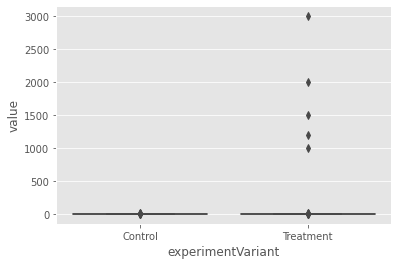

In [168]:
sns.boxplot (data=data1, y='value', x='experimentVariant')
#видны 5 выбросов

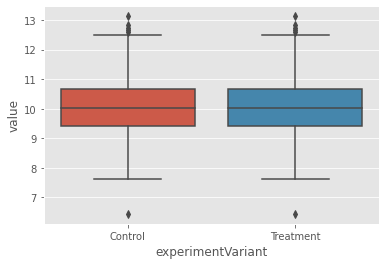

In [170]:
sns.boxplot (data=data1.query('value<500'), y='value', x='experimentVariant')
#при исключении выбросов боксплоты практически идентичны

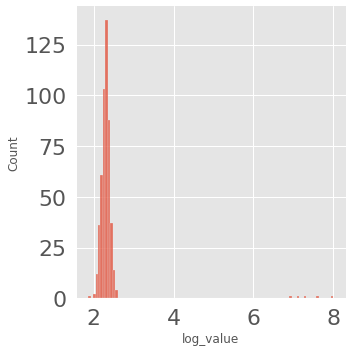

In [188]:
#сделаем логарифмирование, чтобы уменьшить влияние выбросов и хоть что-то разглядеть на графике
data1['log_value']=np.log (data1['value']) 
sns.displot (data=data1[data1['experimentVariant']=="Treatment"], x='log_value',bins=100)

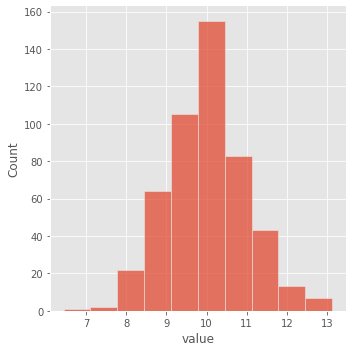

In [100]:
a = data1[data1['experimentVariant']=="Treatment"].query('value<500')
sns.displot (data=a, x='value',bins=10)
#при исключении 5 выбросов форма распределения в группе Treatment становится примерно нормальной

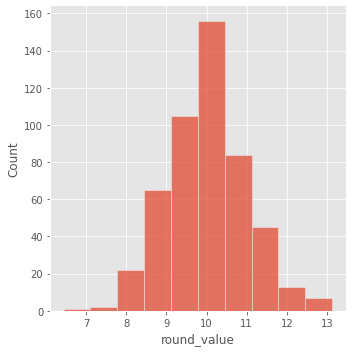

In [8]:
sns.displot (data=data1[data1['experimentVariant']=="Control"], x='round_value',bins=10)
#в контрольной группе распределение нормальное

In [105]:
Treated = data1[data1['experimentVariant']=="Treatment"]['value'] 
Controls = data1[data1['experimentVariant']=="Control"]['value']
Treated_trimm = data1[data1['experimentVariant']=="Treatment"].query('value<500')['value'] #value для Treatments без выбросов

In [92]:
stats.shapiro (Controls)
#Распределение статистически значимо не отклоняется от нормального в подгруппе Controls

ShapiroResult(statistic=0.9936519861221313, pvalue=0.034097425639629364)

In [93]:
stats.shapiro (Treated) 
#распределение статистически значимо отклоняется от нормального в подгруппе Treatment, Student t-test использовать нельзя

ShapiroResult(statistic=0.19973421096801758, pvalue=1.5265745470354557e-41)

In [94]:
stats.levene (Controls, Treated)
#дисперсии в подгруппах не равны

LeveneResult(statistic=4.817835287955753, pvalue=0.028396424031491906)

In [95]:
#Students t-test (подходит только при равенстве дисперсии и нормальном распределении) 
stats.ttest_ind(Controls, Treated)
#выявлены статистически значимые отличия, но доверять им нельзя, 
#так как применение Т-теста Стьюдента подразумевает нормальное распределение и равенство дисперсий в выборках

Ttest_indResult(statistic=-2.1379349959049563, pvalue=0.03276440163234999)

In [80]:
pg.ttest (Controls, Treated, correction=True) #Welch t-test с поправкой на неравенство дисперсий также даёт статистически значимые различия

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.137935,535.10041,two-sided,0.032974,"[-0.1, -0.0]",0.135215,0.67,0.56984


In [172]:
pg.ttest (Controls, Treated_trimm, correction=True) #при исключении выбросов отличий между группами нет

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.082992,992.92318,two-sided,0.933875,"[-0.12, 0.13]",0.005262,0.071,0.050788


In [81]:
pg.mwu (Controls, Treated)
#Применяем тест Манна-Уитни - отличия между группами статистически не значимы (p>0.05). 
#Действительно на бокс-плотах группы примерно равны за исключением 5 выбросов.
#Тест Манна-Уитни использует ранжирование и при этом не учитывает насколько сильно отличаются значения друг от друга, 
#поэтому влияние 5 выбросов будет минимально
#но при помощи Манна-Уитни мы не узнаем где именно находятся эти выбросы

,U-val,alternative,p-val,RBC,CLES
MWU,124189.5,two-sided,0.859215,0.006484,0.496758


In [173]:
pg.mwu (Controls, Treated_trimm)

,U-val,alternative,p-val,RBC,CLES
MWU,124189.5,two-sided,0.922839,-0.003552,0.501776


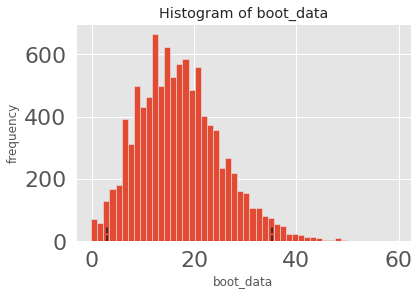

In [204]:
booted_mean = get_bootstrap (Treated, Controls) 
#считаем бутстрап для среднего (хотя среднее - плохая метрика в этом случае, так как слишком чувствительна к выбросам)

In [210]:
booted_mean["p_value"] 
#бутстрап для средних значимо отличается, так как среднее более чувствительно к выбросам

0.03722576495604643

In [206]:
booted_mean["ci"] #Ноль не входит в интервал

,0
0.025,3.020351
0.975,35.227841


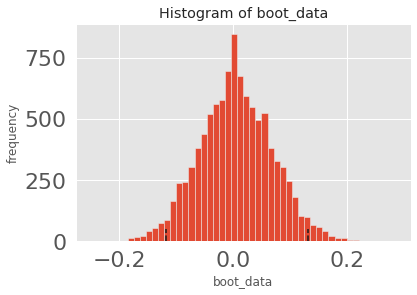

In [207]:
booted_median = get_bootstrap (Treated, Controls, statistic=np.median) 

In [208]:
booted_median["p_value"] 
#бутстрап для медиан значимо не отличается, так как медиана менее чувствительна к выбросам

0.9418165802651225

In [209]:
booted_median["ci"] #0 попадает в доверительный интервал - отвергаем гипотезу о разности медиан

,0
0.025,-0.118042
0.975,0.132189


In [197]:
#основные выбросы находятся за 90% процентилем, можно посчитать значимо ли отличается разность между 90 процентилями в наших выборках
def get_bootstrap_quant(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.quantile, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1, 0.9) - statistic (samples_2, 0.9)) # считаем 90% процентиль
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

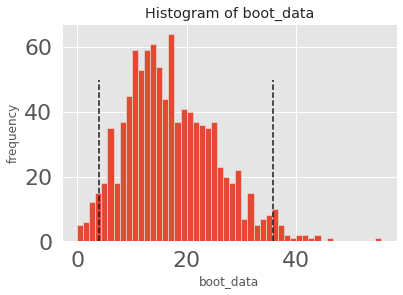

In [200]:
booted_q90 = get_bootstrap (Treated, Controls) 

In [201]:
booted_q90["p_value"] #значения 90% процентиля действительно статистически значимо отличаются (что логично)

0.03826262052993142

In [202]:
booted_q["ci"]

,0
0.025,2.880594
0.975,35.269742


ОБЩИЙ ВЫВОД
В идеале нужно повнимательнее посмотреть на эти выбросы, узнать откуда они взялись - не ошибка ли это при сборе данных?
Если выбросы - результат бага, то очевидно нужно убрать их из анализа и применять т-тест Стьюдента.
Если нет, то т-тест Стьюдента или Уэлча использовать нельзя из-за отклонения от нормальности распределения в подгруппе Treatment.
Манн-Уитни даёт нам мало информации - он говорит, что в целом форма распределения между двумя подгруппами не отличается
Бутстрап для средних применять нельзя, так как при наличии выбросов средние не явлется корректным отражением распределения.
Медиана не так подвержена влиянию выбросов, бутстрап для медиан покажет, что в среднем подгруппы не отличаются.
Бутстрап для 90 процентиля позволит нам подтвердить, что есть значимые отличия в наибольших значениях.
Не уверен, что имеет смысл считать значимость различий для остальных процентилей, так как это будет уже p-Hacking. 
Если мы для всех децилей например посчитаем различия, то нужно будет вводить поправку на множественное сравнение.